In [1]:
from typing import Callable, List, Tuple, Union

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
import copy

print("Finished importing packages")

Finished importing packages


## Systems of *linear* equations in $\mathbb{R}^n$
The aim of the distillation column in the picture is to separate a multi-component inlet stream, containing Methane (M), Ethane (E) and Propane (P).

The inlet stream is fully defined concerning the mass. You are required to find the values of $m_1$, $m_2$, and $m_3$, defining respectively, the total mass of the top, middle and bottom stream. The component mass fractions of the single streams are given as known data.

Remember that: 

$x_{ji} = \frac{m_j}{m_{tot_i}}$      and      $\sum_j x_{ji} = 1$

with $j \in N_c$ and $i \in N_s$ with $N_c$ components and $N_s$ streams.

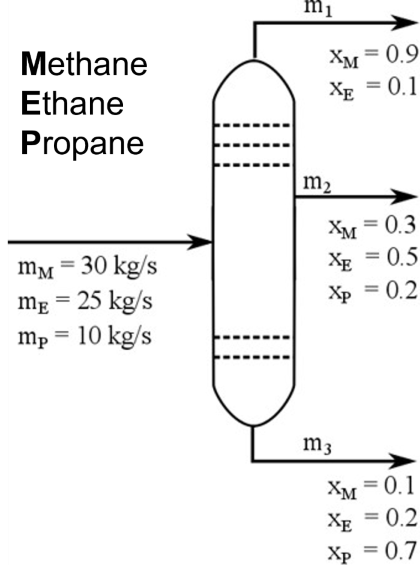

To solve the problem, we are required to set up a component mass balance, for each component M, E and P. The balance results in a linear system of three equations in the unknowns $m_1$, $m_2$, $m_3$. A linear system can be written in the form 
\begin{equation}
\tag{Eq. 1}
\boldsymbol{A}\vec{x} = \vec{b}, 
\end{equation}
with $A$ being the coefficients matrix, $b$ the known vector and $x$ the unknown vector. The linear system can be solved as $\vec{x} = \boldsymbol{A}^{-1}\vec{b}$.

- Using `numpy`, we define the matrix of coefficients $\boldsymbol{A}$ and the vector of known values $\vec{b}$, called `a_matrix` and `b_vector`, respectively.
- We solve the linear system using the Jacobi method.
- We compare our solution to the solution derived by using the Python built-in function `numpy.linalg.solve`.

In [2]:
# Define a_matrix, b_vector
a_matrix = np.array([[0.9, 0.3, 0.1], [0.1, 0.5, 0.2], [0.0, 0.2, 0.7]]) 
b_vector = np.array([30.0, 25.0, 10.0])

The **fixed point iteration** method can be exploited to solve linear systems in the following form:
\begin{equation}
\tag{Eq. 2}
\vec{x}_{i+1} = \mathbf{C}\vec{x}_{i} + \vec{g}
\end{equation}
Depending on the specific algorithm (Richardson, Jacobi, Gauss-Seidel, etc.) the way matrix $\mathbf{C}$ and vector $\vec{g}$ are defined is different. However, the iterative solution will follow equation $2$ for all algorithms. For this reason, we define the `fixedPointIteration` function (recall Q1 - Lecture 2) that takes as input the following arguments:
- a matrix `C`
- a vector `g`
- a first-guess solution `x0`
- a maximum number of iteration `nIter`
- a absolute error tolerance `eps`

The function is able to iteratively approach the solution using fixed point iterations (equation $2$) until one of these two conditions is met: 
1. The approximated absolute error is smaller than a given value $\left(\varepsilon = 1 \cdot 10^{-9}\right)$
2. The code has run for a given maximum number of iterations $\left(N = 100\right)$

The approximated absolute error $\varepsilon$ at the `i-th` iteration can be defined as
\begin{equation}
\tag{Eq. 3}
\varepsilon = \left| \vec{x}_{i}-\vec{x}_{i-1} \right|
\end{equation}
The function then returns the solution vector `x` and print out the number of iterations used to converge (this feature will be useful to compare the efficiency of different algorithms).

In [3]:
def fixedPointIteration(C: np.ndarray, g: np.ndarray, x0: np.ndarray, nIter:int=100, eps:float=1e-9) -> np.ndarray:
    """Method to solve linear systems via fixed point iteration method.

    Args:
        C (np.ndarray): Matrix C
        g (np.ndarray): Vector b
        x0 (np.ndarray): Initial guess
        nIter (int, optional): Maximum number of iterations. Defaults to 100.
        eps (float, optional): Absolute error tolerance. Defaults to 1e-9.

    Returns:
        np.ndarray: Solution vector x
    """
    # BEGIN SOLUTION
    # assigning first-guess solution to the solution vector x
    x = x0

    # start iterating
    for i in range(1, nIter + 1):
        # save the solution of the previous iteration
        x_old = x
        # determine new solution vector @ i-th iteration knowing the (i-1)-th one
        x = np.dot(C, x) + g
        # compute the approximated absolute error
        error = np.linalg.norm(x - x_old)

        if error < eps:
            # Method has converged in i iterations
            print(f"Method converged in {i} iterations.")
            return x
    # Maximum number of iterations was reached, the method hasn't converged
    # END SOLUTION
    return x

First, we need to find out how to define the decomposition of matrix $\boldsymbol{A}$ into $\boldsymbol{D}$, $\boldsymbol{L}$, and $\boldsymbol{U}$. Herefore, we can use the built-in numpy functions `numpy.diag`, `numpy.tril`, and `numpy.triu`. 

Then, we define a function that reformulates the problem such that the `fixedPointIteration` function can be used, i.e., in the form
\begin{equation}
\tag{Eq. 4}
\vec{x}_{i+1} = \mathbf{C}\vec{x}_{i} + \vec{g}.
\end{equation}

In the case of the Jacobi method, matrix $\boldsymbol{C}$ can be defined as
\begin{equation}
\tag{Eq. 5}
\mathbf{C}=\mathbf{D}^{-1}(-\mathbf{L}-\mathbf{U}).
\end{equation}

Analogously, the vector $g$ needs to be defined as 
\begin{equation}
\tag{Eq. 6}
\vec{g}=\mathbf{D}^{-1}\vec{b}.
\end{equation}

The function `jacobi` takes as input arguments
- a matrix `A`
- a vector `b`
- a first-guess solution `x0`
- a maximum number of iteration `nIter`
- a absolute error tolerance `eps`.

The `jacobi` function shall return a function call of the `fixedPointIteration` with the respective input arguments:
- a matrix `C`
- a vector `g`
- a first-guess solution `x0`
- a maximum number of iteration `nIter`
- a absolute error tolerance `eps`.


In [4]:
def jacobi(A: np.ndarray, b: np.ndarray, x0: np.ndarray, nIter:int=100, eps:int=1e-9) -> Callable:
    """
        Args:
        A (np.ndarray): linear system matrix
        b (np.ndarray): linear system RHS vector
        x0 (np.ndarray): first guess solution
        nIter (int): maximum number of iterations
        eps (float): absolute tolerance

    Returns:
        (np.ndarray): array with the solution.
    """

    # define C matrix according to jacobi algorithm
    C = np.dot(np.diag(1.0 / np.diag(A)), -np.tril(A, -1) - np.triu(A, +1))
    # define b vector according to jacobi algorithm
    g = np.dot(np.diag(1.0 / np.diag(A)), b)

    return fixedPointIteration(C, g, x0, nIter, eps)

We now compare the solution of the Jacobi method to the solution output by invoking the _[`numpy.linalg.solve()`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html)_ to solve the linear system (equation $1$).

In [5]:
y = np.linalg.solve(a_matrix, b_vector)

# BEGIN SOLUTION
x0 = np.zeros(len(b_vector))
print("Jacobi method:")
x_jacobi = jacobi(a_matrix, b_vector, x0, nIter=100, eps=1e-9)
print(x_jacobi)
print("Absolute error between our jacobi method and numpy.linalg.solve(): {:.2e}\n\n".format(np.linalg.norm(x_jacobi - y)))

Jacobi method:
Method converged in 32 iterations.
[17.88461538 45.96153846  1.15384615]
Absolute error between our jacobi method and numpy.linalg.solve(): 1.80e-10


